In [379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set(rc={'figure.figsize':(14,8)})

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

import joblib

In [345]:
os.listdir(path='data')

['mitbih_test.csv',
 'mitbih_train.csv',
 'ptbdb_abnormal.csv',
 'ptbdb_normal.csv']

In [346]:
train_set = pd.read_csv('data/mitbih_train.csv', header=None)
test_set = pd.read_csv('data/mitbih_test.csv', header=None)

In [347]:
train_set.shape

(87554, 188)

In [348]:
test_set.shape

(21892, 188)

In [349]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [350]:
# Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
# 0=normal (N), 1=SVEB (S), 2=VEB (V), 3=Fusion beat (F), 4=Unknown beat (Q)

"""
• N: Normal beat
• S: Supraventricular premature beat
• V: Premature ventricular contraction
• F: Fusion of ventricular and normal beat
• Q: Unclassifiable beat

N
Normal
Left/Right bundle branch block
Atrial escape
Nodal escape

S
Atrial premature
Aberrant atrial premature
Nodal premature
Supra-ventricular premature

V
Premature ventricular contraction
Ventricular escape

F
Fusion of ventricular and normal

Q
Paced
Fusion of paced and normal
Unclassifiable
""";

<AxesSubplot:>

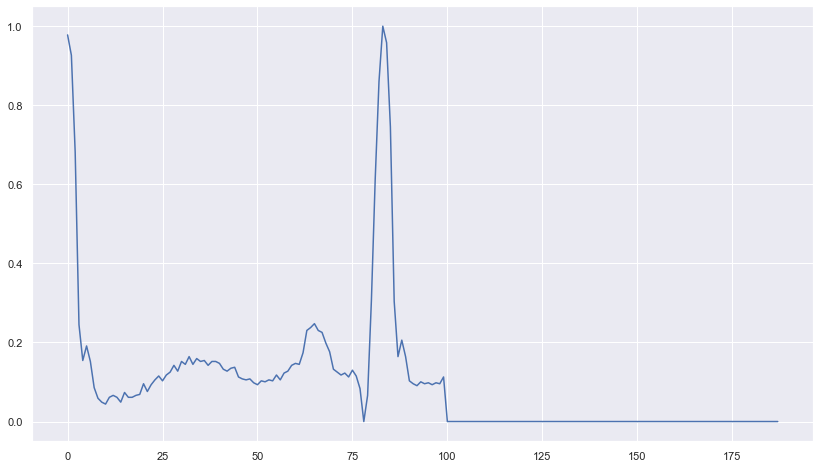

In [351]:
# each row represents one cardiac cycle (heartbeat)
train_set.iloc[0].plot()

In [352]:
# unbalanced classes
train_set.iloc[:, 187].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

In [353]:
test_set.iloc[:, 187].value_counts()

0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64

In [354]:
# number of columns with at least one null value
len(train_set.columns[train_set.isnull().any()])

0

In [355]:
# resample to balance the classes - will aim to keep ~same amount as original data
def balance_classes(data, class_size=0):
    labels_0 = data[data[187]==0].sample(n=class_size,random_state=42)
    labels_1 = data[data[187]==1]
    labels_2 = data[data[187]==2]
    labels_3 = data[data[187]==3]
    labels_4 = data[data[187]==4]
    
    labels_1_up = resample(labels_1, replace=True, n_samples=class_size, random_state=33)
    labels_2_up = resample(labels_2, replace=True, n_samples=class_size, random_state=34)
    labels_3_up = resample(labels_3, replace=True, n_samples=class_size, random_state=35)
    labels_4_up = resample(labels_4, replace=True, n_samples=class_size, random_state=36)
    
    final_df = pd.concat([labels_0, labels_1_up, labels_2_up, labels_3_up, labels_4_up])
    
    return final_df

In [356]:
train_set_balanced = balance_classes(train_set, class_size=18000)
test_set_balanced = balance_classes(test_set, class_size=4400)

In [357]:
train_set_balanced.iloc[:, 187].value_counts()

0.0    18000
4.0    18000
3.0    18000
1.0    18000
2.0    18000
Name: 187, dtype: int64

In [358]:
test_set_balanced.iloc[:, 187].value_counts()

0.0    4400
4.0    4400
2.0    4400
3.0    4400
1.0    4400
Name: 187, dtype: int64

In [359]:
# randomly sample training data and plot
def plot_random_rows(data, num_samples=0):
    data = data.iloc[:, :-1]
    shuffled_indices = np.random.permutation(len(data))
    indices_to_plot = shuffled_indices[:num_samples]
    random_data = data.iloc[indices_to_plot]
    
    return random_data.T.plot(legend=False, cmap='coolwarm')

<AxesSubplot:>

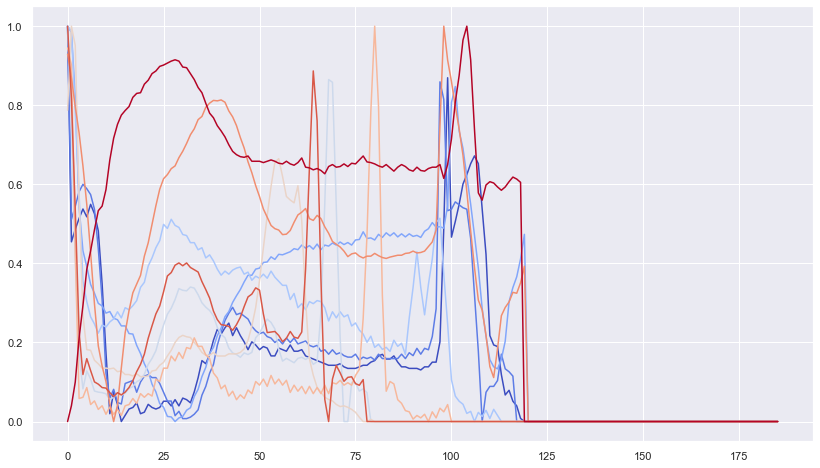

In [360]:
plot_random_rows(X_train, num_samples=10)

In [361]:
# randomly sample training data and plot
def subplot_random_rows(data, num_samples=0):
    data = data.iloc[:, :-1]
    shuffled_indices = np.random.permutation(len(data))
    indices_to_plot = shuffled_indices[:num_samples]
    random_data = data.iloc[indices_to_plot]
    
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.plot(np.arange(0,186), random_data.iloc[i,:])
    
    return plt.show()

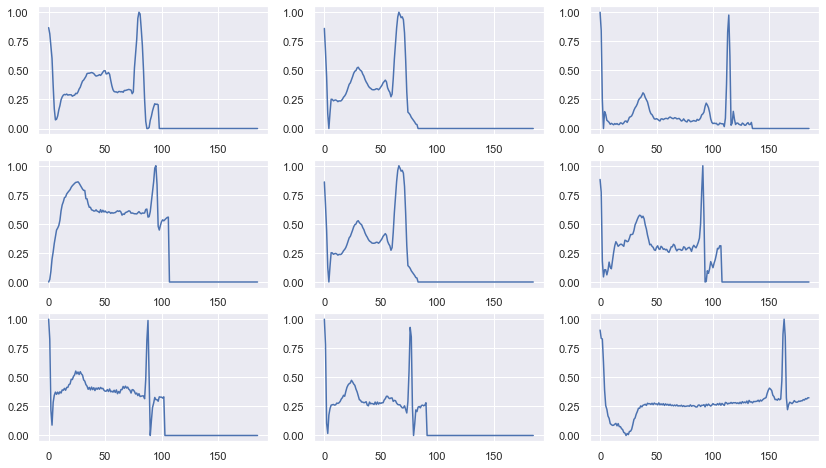

In [362]:
subplot_random_rows(X_train, num_samples=9)

In [363]:
# split data into features and labels
X_train = train_set_balanced.iloc[:, :-1]
y_train = train_set_balanced.iloc[:, -1]

In [375]:
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')

X_train shape: (90000, 187), y_train shape: (90000,)


In [364]:
# set aside validation set
X_test, X_val, y_test, y_val = train_test_split(test_set_balanced.iloc[:, :-1], 
                                                test_set_balanced.iloc[:, -1], 
                                                test_size=0.3,
                                                random_state=42)

In [365]:
# data already scaled between 0-1
#scaler = MinMaxScaler(feature_range=(0, 1))

In [366]:
# relu activation is default
mlp = MLPClassifier(hidden_layer_sizes=(75, 75, 75), max_iter=300)

mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(75, 75, 75), max_iter=1000)

In [367]:
joblib.dump(mlp, "EKG_nn.pkl")

['EKG_nn.pkl']

In [368]:
y_pred = mlp.predict(X_test)

In [381]:
# which metrics to evaluate on?
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.97      0.85      3102
         1.0       0.97      0.79      0.87      3025
         2.0       0.93      0.93      0.93      3089
         3.0       0.97      0.87      0.92      3071
         4.0       0.99      0.98      0.98      3113

    accuracy                           0.91     15400
   macro avg       0.92      0.91      0.91     15400
weighted avg       0.92      0.91      0.91     15400



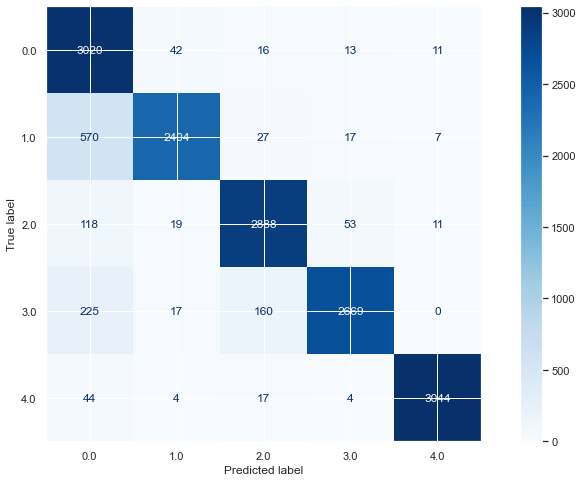

In [402]:
plot_confusion_matrix(mlp, X_test, y_test, cmap='Blues')

In [378]:
y_pred.shape

(15400,)